In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F
import os
import glob
from torch.utils import data

In [2]:
torch.__version__

'1.12.1'

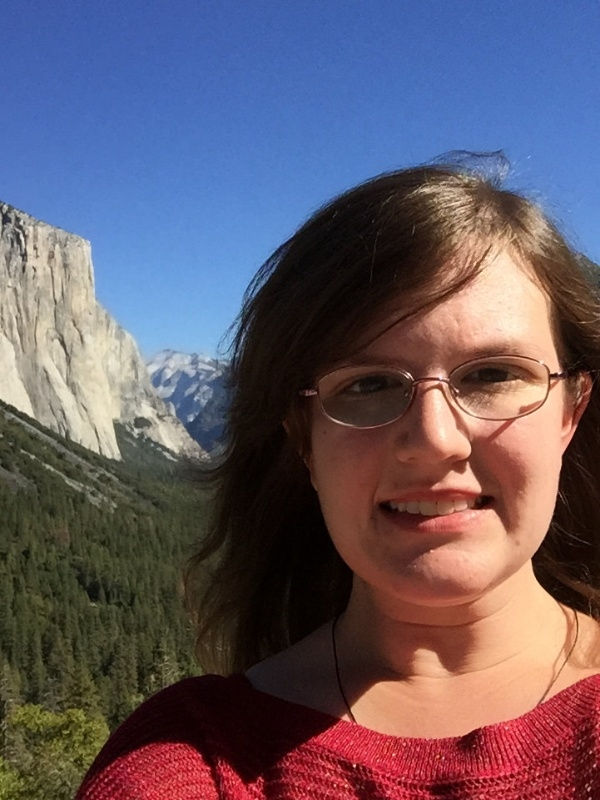

In [3]:
# 显示1张图片
res = Image.open(r'F:\hk\training\00001.png')
res

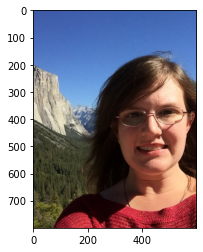

In [4]:
# 用plt的形式展示
pil_img = Image.open(r'F:\hk\training\00001.png')
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()


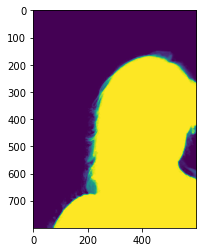

In [5]:
pil_img = Image.open(r'F:\hk\training\00001_matte.png')
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

In [6]:
# 查看原图像有多少像素值
np.unique(np_img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [7]:
np_img.max(),np_img.min(),np_img.shape

(255, 0, (800, 600))

In [8]:
np_img.shape

(800, 600)

In [9]:
np_img[np_img>0] = 1

In [10]:
np_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [11]:
# 构建训练集， 测试集
all_pics = glob.glob(r'F:\hk\training\*.png')
all_pics[:5]

['F:\\hk\\training\\00001.png',
 'F:\\hk\\training\\00001_matte.png',
 'F:\\hk\\training\\00002.png',
 'F:\\hk\\training\\00002_matte.png',
 'F:\\hk\\training\\00003.png']

In [12]:
images= [p for p in all_pics if 'matte' not in p]

In [13]:
len(images)

1700

In [14]:
annotations = [p for p in all_pics if 'matte'  in p]

In [15]:
len(annotations)

1700

In [16]:
# 随便取出一张来
np.random.seed(2023)
index = np.random.permutation(len(images))
index

array([ 630, 1065,   14, ...,  454, 1561,  855])

In [17]:
images = np.array(images)[index]

In [18]:
images[:5]

array(['F:\\hk\\training\\00631.png', 'F:\\hk\\training\\01066.png',
       'F:\\hk\\training\\00015.png', 'F:\\hk\\training\\01167.png',
       'F:\\hk\\training\\01187.png'], dtype='<U24')

In [19]:
anno = np.array(annotations)[index]
anno[:5]

array(['F:\\hk\\training\\00631_matte.png',
       'F:\\hk\\training\\01066_matte.png',
       'F:\\hk\\training\\00015_matte.png',
       'F:\\hk\\training\\01167_matte.png',
       'F:\\hk\\training\\01187_matte.png'], dtype='<U30')

In [20]:
# test 和 train 是平行的
# 构建训练集， 测试集
all_test_pics = glob.glob(r'F:\hk\testing\*.png')
test_images = [p for p in all_test_pics if 'matte' not in p]
test_anno = [p for p in all_test_pics if 'matte' in p]

In [21]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [22]:
# 这个方法很有用, 让训练集和测试集有了  切片的功能
class Portrait_dataset(data.Dataset):
    def __init__(self, img_paths, anno_paths) -> None:
        super().__init__()
        self.imgs = img_paths
        self.annos = anno_paths
    
    def __getitem__(self, index):
        img = self.imgs[index]
        anno = self.annos[index]

        pil_img = Image.open(img)
        img_tensor = transform(pil_img)

        anno_img = Image.open(anno)
        anno_tensor = transform(anno_img)
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        anno_tensor[anno_tensor>0] = 1
        return img_tensor, anno_tensor
    
    def __len__(self):
        return len(self.imgs)

In [23]:
train_dataset = Portrait_dataset(images, anno)
test_dataset = Portrait_dataset(test_images, test_anno)
BATCH_SIZE = 12

In [24]:
train_dl = data.DataLoader(
                           train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
)

In [25]:
test_dl = data.DataLoader(
                          test_dataset,
                          batch_size=BATCH_SIZE,
)

In [26]:
imgs_batch, annos_batch = next(iter(train_dl))

In [27]:
img = imgs_batch[0].permute(1,2,0).numpy()
anno = annos_batch[0].numpy()

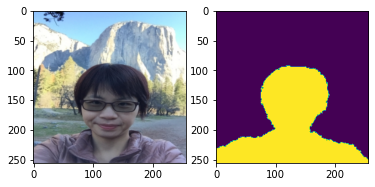

In [28]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(anno)

In [29]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

        

In [30]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(2*channels,channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels,channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(
                channels,
                channels//2, 
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        
        self.up = nn.Sequential(
                               nn.ConvTranspose2d(1024, 
                                                  512, 
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=1,
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        self.conv_2 = Downsample(128, 64)
        self.last = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.up(x5)
        
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024
        x5 = self.up1(x5)                         # 64*64*256)
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512  
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        
        x5 = self.last(x5)                        # 256*256*3
        return x5

In [32]:
model = Net()

In [33]:
if torch.cuda.is_available():
    model.to('cuda')

In [34]:
loss_fn = nn.CrossEntropyLoss()

In [35]:
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [37]:
epochs = 30

In [38]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.05 accuracy: 0.689 test_loss：  0.042 test_accuracy: 0.744
epoch:  1 loss：  0.035 accuracy: 0.816 test_loss：  0.033 test_accuracy: 0.831
epoch:  2 loss：  0.029 accuracy: 0.853 test_loss：  0.028 test_accuracy: 0.858
epoch:  3 loss：  0.027 accuracy: 0.864 test_loss：  0.026 test_accuracy: 0.872
epoch:  4 loss：  0.026 accuracy: 0.873 test_loss：  0.028 test_accuracy: 0.865
epoch:  5 loss：  0.025 accuracy: 0.878 test_loss：  0.025 test_accuracy: 0.873
epoch:  6 loss：  0.024 accuracy: 0.884 test_loss：  0.025 test_accuracy: 0.869
epoch:  7 loss：  0.021 accuracy: 0.898 test_loss：  0.021 test_accuracy: 0.895
epoch:  8 loss：  0.02 accuracy: 0.905 test_loss：  0.021 test_accuracy: 0.899
epoch:  9 loss：  0.019 accuracy: 0.908 test_loss：  0.02 test_accuracy: 0.902
epoch:  10 loss：  0.018 accuracy: 0.911 test_loss：  0.019 test_accuracy: 0.905
epoch:  11 loss：  0.018 accuracy: 0.914 test_loss：  0.019 test_accuracy: 0.907
epoch:  12 loss：  0.017 accuracy: 0.917 test_loss：  0.019 test_ac